# Logistic Falkon model test
tutorial for the Logistic model

In [1]:
%matplotlib inline
from sklearn import datasets, model_selection
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import falkon

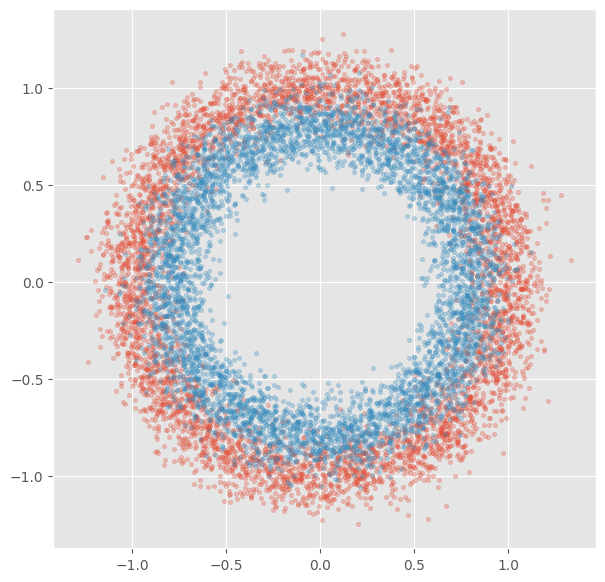

In [2]:
X, Y = datasets.make_circles(
    n_samples=10_000, shuffle=False, noise=0.1, random_state=122)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[Y == 0,0], X[Y == 0,1], alpha=0.3, marker='.')
_ = ax.scatter(X[Y == 1,0], X[Y == 1,1], alpha=0.3, marker='.')

In [3]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, test_size=0.2, random_state=10, shuffle=True)

In [4]:
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)
Y_train = torch.from_numpy(Y_train).to(dtype=torch.float32).reshape(-1, 1)
Y_test = torch.from_numpy(Y_test).to(dtype=torch.float32).reshape(-1, 1)

Y_train[Y_train == 0] = -1
Y_test[Y_test == 0] = -1

In [5]:
def binary_loss(true, pred):
    return torch.mean((true != torch.sign(pred)).to(torch.float32))



In [6]:
# We define some basic options to run on the CPU, and to disable keops
flk_opt = falkon.FalkonOptions(use_cpu=False, keops_active="auto")
flk_kernel = falkon.kernels.GaussianKernel(1, opt=flk_opt)
flk = falkon.Falkon(kernel=flk_kernel, penalty=1e-7, M=1000, options=flk_opt)

In [7]:
logflk_opt = falkon.FalkonOptions(use_cpu=False, keops_active="auto")

logflk_kernel = falkon.kernels.GaussianKernel(1, opt=logflk_opt)
logloss = falkon.gsc_losses.LogisticLoss(logflk_kernel)

penalty_list = [1e-3, 1e-5, 1e-7, 1e-7, 1e-7]
iter_list = [4, 4, 4, 8, 5000]

logflk = falkon.LogisticFalkon(
    kernel=logflk_kernel, penalty_list=penalty_list, iter_list=iter_list, M=1000, loss=logloss,
    error_fn=binary_loss, error_every=1, options=logflk_opt)


In [8]:
%%time
flk.fit(X_train, Y_train)

CPU times: user 24.6 s, sys: 782 ms, total: 25.4 s
Wall time: 4.07 s


Falkon(M=1000, center_selection=<falkon.center_selection.UniformSelector object at 0x7fd6d6577790>, kernel=GaussianKernel(sigma=Parameter containing:
tensor([1.], dtype=torch.float64)), options=FalkonOptions(keops_acc_dtype='auto', keops_sum_scheme='auto', keops_active='auto', keops_memory_slack=0.7, chol_force_in_core=False, chol_force_ooc=False, chol_par_blk_multiplier=2, pc_epsilon_32=1e-05, pc_epsilon_64=1e-13, cpu_preconditioner=False, cg_epsilon_32=1e-07, cg_epsilon_64=1e-15, cg_tolerance=1e-07, cg_full_gradient_every=10, cg_differential_convergence=False, debug=False, use_cpu=False, max_gpu_mem=inf, max_cpu_mem=inf, compute_arch_speed=False, no_single_kernel=True, min_cuda_pc_size_32=10000, min_cuda_pc_size_64=30000, min_cuda_iter_size_32=300000000, min_cuda_iter_size_64=900000000, never_store_kernel=False, store_kernel_d_threshold=1200, num_fmm_streams=2, memory_slack=0.9), penalty=1e-07)

In [9]:
%%time
logflk.fit(X_train, Y_train)

Iteration 0 - penalty 1.000000e-03 - sub-iterations 4


Iteration   0 - Elapsed 16.43s - training loss 0.4697 - training error 0.1544 
Iteration 1 - penalty 1.000000e-05 - sub-iterations 4
Iteration   1 - Elapsed 16.46s - training loss 0.3774 - training error 0.1546 
Iteration 2 - penalty 1.000000e-07 - sub-iterations 4
Iteration   2 - Elapsed 16.50s - training loss 0.3577 - training error 0.1531 
Iteration 3 - penalty 1.000000e-07 - sub-iterations 8
Iteration   3 - Elapsed 16.55s - training loss 0.3554 - training error 0.1535 
Iteration 4 - penalty 1.000000e-07 - sub-iterations 5000
Iteration   4 - Elapsed 37.30s - training loss 0.3554 - training error 0.1530 
CPU times: user 33.6 s, sys: 2.64 s, total: 36.3 s
Wall time: 37.4 s


LogisticFalkon(M=1000, center_selection=<falkon.center_selection.UniformSelector object at 0x7fd7959fd8e0>, error_fn=<function binary_loss at 0x7fd6d656e160>, iter_list=[4, 4, 4, 8, 5000], kernel=GaussianKernel(sigma=Parameter containing:
tensor([1.], dtype=torch.float64)), loss=LogisticLoss(kernel=GaussianKernel(sigma=Parameter containing:
tensor([1.], dtype=torch.float64))), options=FalkonOptions(keops_acc_dtype='auto', keops_sum_scheme='auto', keops_active='auto', keops_memory_slack=0.7, chol_force_in_core=False, chol_force_ooc=False, chol_par_blk_multiplier=2, pc_epsilon_32=1e-05, pc_epsilon_64=1e-13, cpu_preconditioner=False, cg_epsilon_32=1e-07, cg_epsilon_64=1e-15, cg_tolerance=1e-07, cg_full_gradient_every=10, cg_differential_convergence=False, debug=False, use_cpu=False, max_gpu_mem=inf, max_cpu_mem=inf, compute_arch_speed=False, no_single_kernel=True, min_cuda_pc_size_32=10000, min_cuda_pc_size_64=30000, min_cuda_iter_size_32=300000000, min_cuda_iter_size_64=900000000, never_store_kernel=False, store_kernel_d_threshold=1200, num_fmm_streams=2, memory_slack=0.9), penalty_list=[0.001, 1e-05, 1e-07, 1e-07, 1e-07])

In [10]:
flk_pred = flk.predict(X_test)
flk_err = binary_loss(Y_test, flk_pred)

logflk_pred = logflk.predict(X_test)
logflk_err = binary_loss(Y_test, logflk_pred)

print("Falkon model          -- Error: %.2f%%" % (flk_err * 100))
print("Logistic Falkon model -- Error: %.2f%%" % (logflk_err * 100))

Falkon model          -- Error: 17.00%
Logistic Falkon model -- Error: 16.95%


In [11]:
def plot_predictions(preds, ax):
    ax.scatter(X_test[((Y_test == -1) & (preds.sign() == Y_test)).reshape(-1), 0],
               X_test[((Y_test == -1) & (preds.sign() == Y_test)).reshape(-1), 1],
               alpha=0.3, marker='.', color='b', label="correct cls 0")
    ax.scatter(X_test[((Y_test == 1) & (preds.sign() == Y_test)).reshape(-1),0],
               X_test[((Y_test == 1) & (preds.sign() == Y_test)).reshape(-1),1],
               alpha=0.3, marker='.', color='r', label="correct cls 1")

    ax.scatter(X_test[((Y_test == -1) & (preds.sign() != Y_test)).reshape(-1), 0],
               X_test[((Y_test == -1) & (preds.sign() != Y_test)).reshape(-1), 1],
               alpha=0.5, marker='x', color='b', label="wrong cls 0")
    ax.scatter(X_test[((Y_test == 1) & (preds.sign() != Y_test)).reshape(-1),0],
               X_test[((Y_test == 1) & (preds.sign() != Y_test)).reshape(-1),1],
               alpha=0.5, marker='x', color='r', label="wrong cls 1")



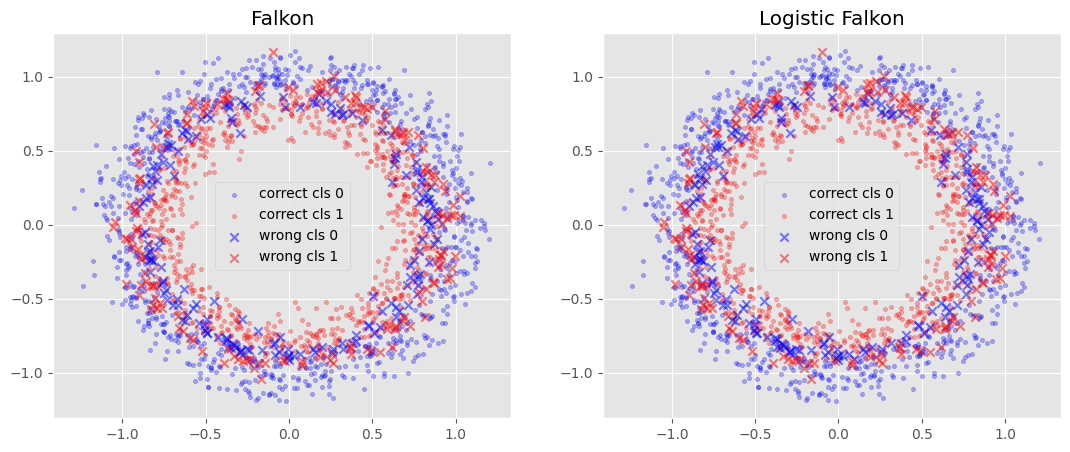

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
plot_predictions(flk_pred, ax[0])
ax[0].set_title("Falkon")
ax[0].legend(loc='best')

plot_predictions(logflk_pred, ax[1])
ax[1].set_title("Logistic Falkon")
ax[1].legend(loc='best')